# ULTIMO PREPROCESAMIENTO

## Lectura de datos

In [1]:
!pip install imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
 
from pylab import rcParams
 
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
 
from collections import Counter

In [3]:
df = pd.read_csv('../data/dataframe_imputed.csv',sep=',', encoding='latin-1', index_col=0, low_memory=False)
df_edit = pd.read_csv('../data_edit/dataframe_edit_imputed.csv',sep=',', encoding='latin-1', index_col=0, low_memory=False)
df_2017 = pd.read_csv('../data/dataframe_2017_imputed.csv',sep=',', encoding='latin-1', index_col=0, low_memory=False)
df_edit_2017 = pd.read_csv('../data_edit/dataframe_2017_edit_imputed.csv',sep=',', encoding='latin-1', index_col=0, low_memory=False)

In [4]:
def correlation(df):
    corrmat = df.corr()
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, annot = True, fmt = '.2f', annot_kws = {'size': 10}, square=True);

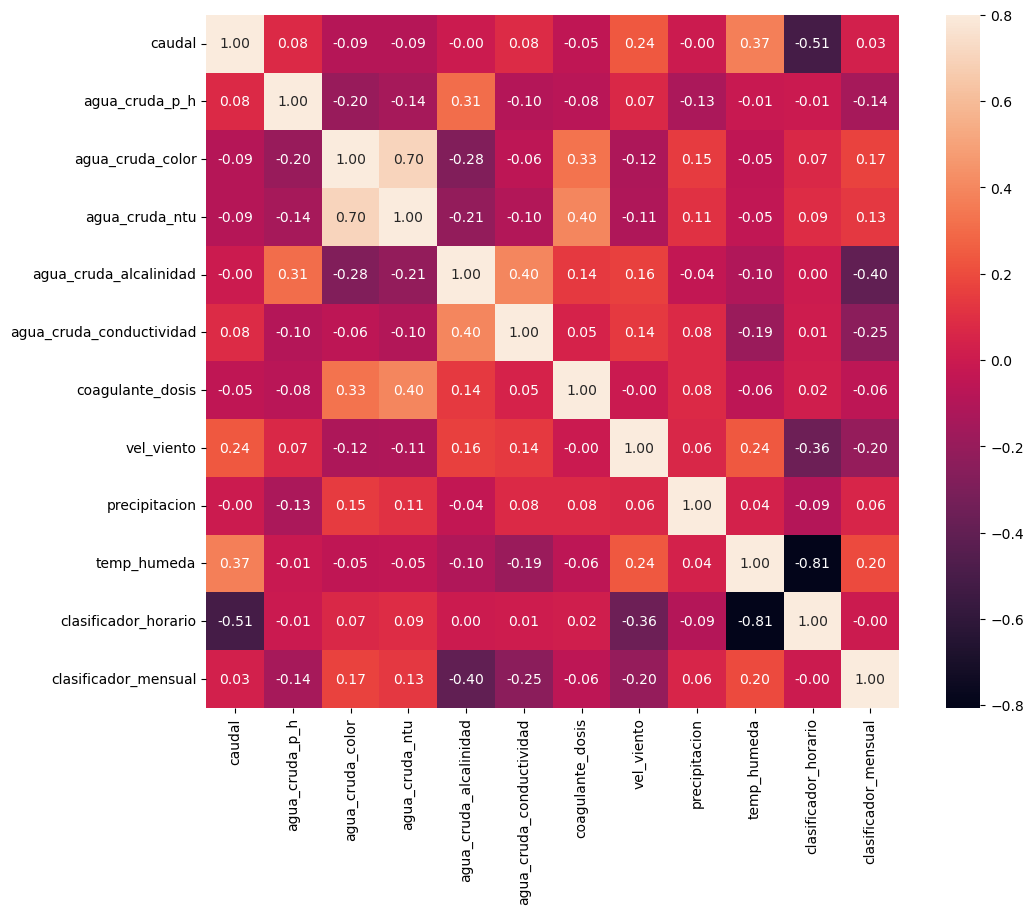

In [5]:
correlation(df)

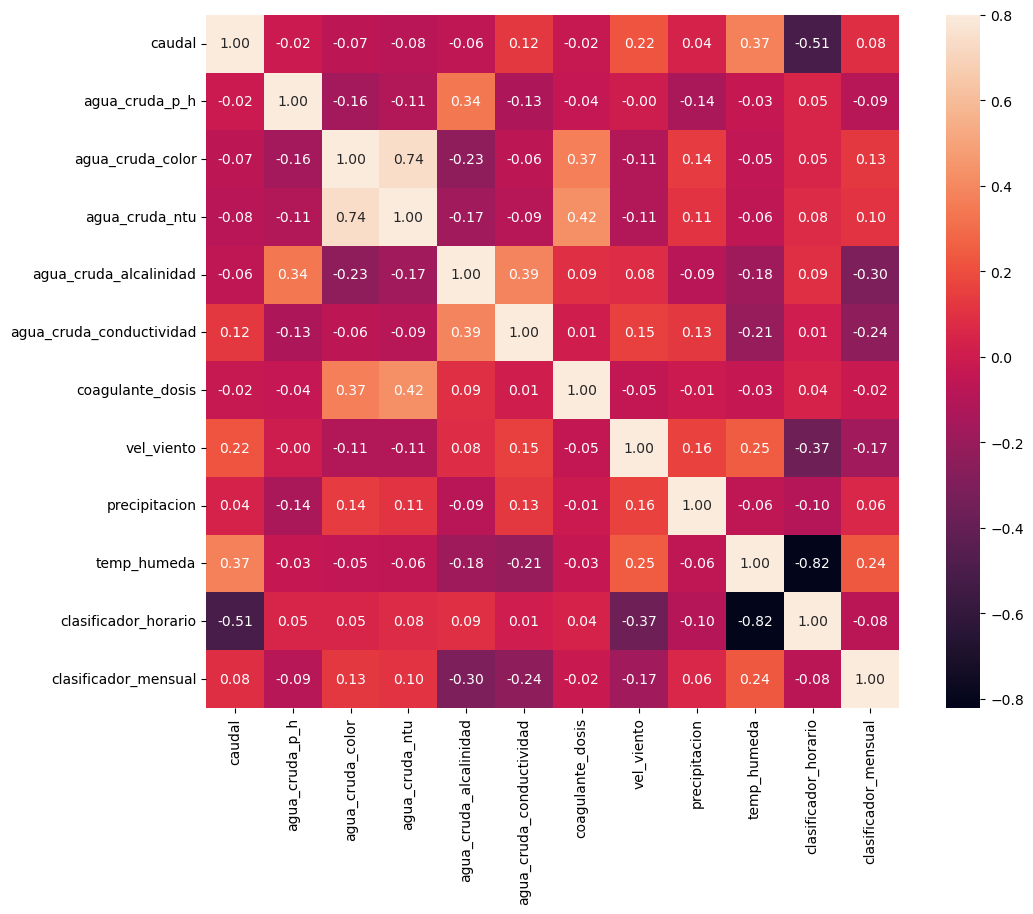

In [6]:
correlation(df_edit)

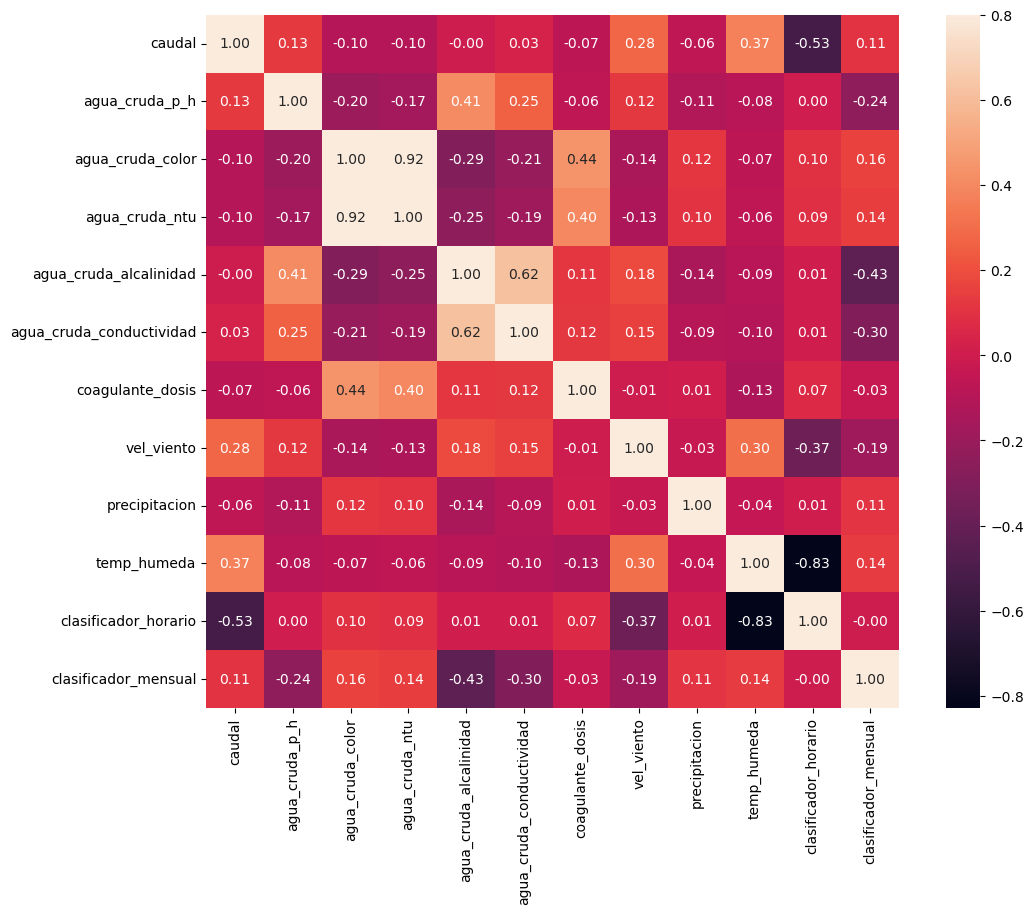

In [7]:
correlation(df_2017)

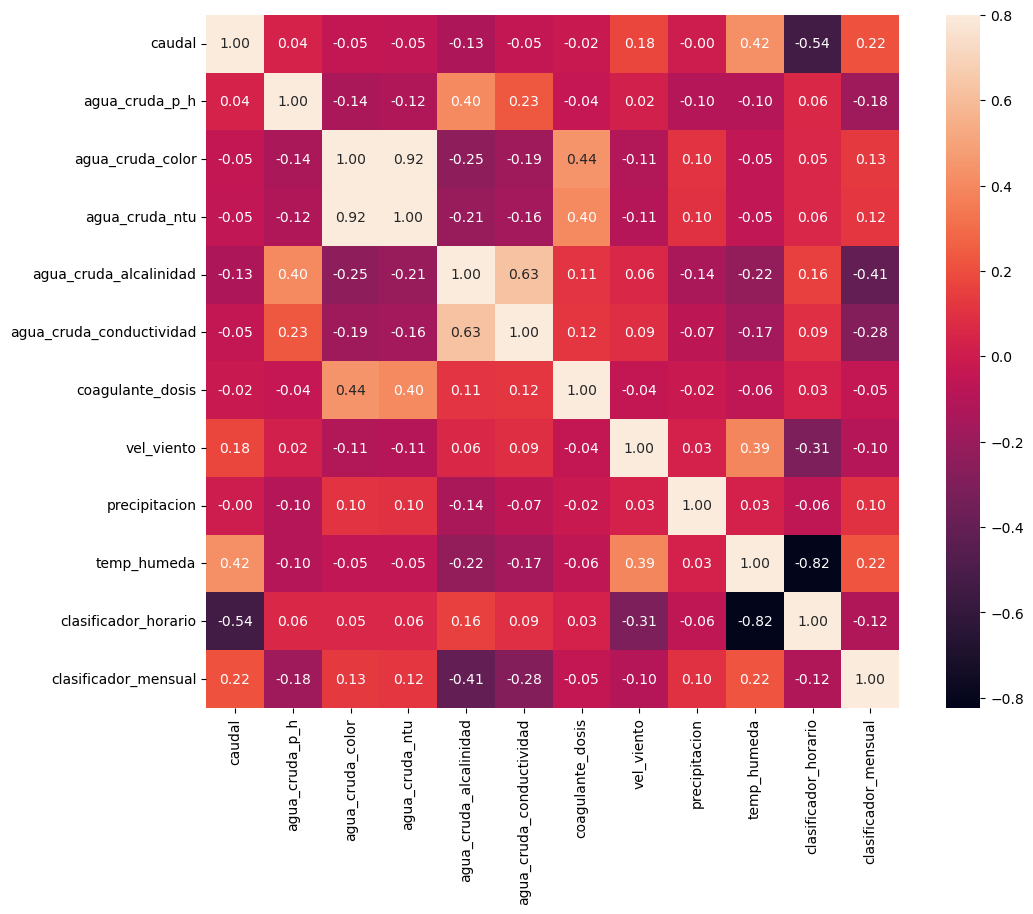

In [8]:
correlation(df_edit_2017)

## Creación de dataframe con dosis de coagulante categórica

In [9]:
def dosage_category(df):
    df = df.copy()
    df['coagulante_dosis'] = df['coagulante_dosis'].astype(float)
    conditions = [
        (df['coagulante_dosis'].between(15, 19.99)),
        (df['coagulante_dosis'].between(20, 24.99)),
        (df['coagulante_dosis'].between(25, 29.99)),
        (df['coagulante_dosis'].between(30, 34.99)),
        (df['coagulante_dosis'].between(35, 39.99)),
        (df['coagulante_dosis'].between(40, 44.99)),
        (df['coagulante_dosis'].between(45, 49.99)),
        (df['coagulante_dosis'].between(50, 99.99))
    ]
    
    values = ['quince', 'veinte', 'veinticinco', 'treinta', 'treinta y cinco', 'cuarenta','cuarenta y cinco','cincuenta']
    
    df['dosis_coagulante'] = np.select(conditions, values, default='no_definido')
    
    return df

In [10]:
df_category = dosage_category(df)
df_edit_category = dosage_category(df_edit)
df_2017_category = dosage_category(df_2017)
df_edit_2017_category = dosage_category(df_edit_2017)
df_category = df_category.drop('coagulante_dosis', axis=1)
df_edit_category = df_edit_category.drop('coagulante_dosis', axis=1)
df_2017_category = df_2017_category.drop('coagulante_dosis', axis=1)
df_edit_2017_category = df_edit_2017_category.drop('coagulante_dosis', axis=1)
df_category['dosis_coagulante'] = df_category['dosis_coagulante'].astype('category')
df_edit_category['dosis_coagulante'] = df_edit_category['dosis_coagulante'].astype('category')
df_2017_category['dosis_coagulante'] = df_2017_category['dosis_coagulante'].astype('category')
df_edit_2017_category['dosis_coagulante'] = df_edit_2017_category['dosis_coagulante'].astype('category')

Por el momento, disponemos de seis dataframes que serán la base para nuestro análisis. Cada conjunto de datos será sujeto a un examen meticuloso, ya que las decisiones que tomaremos estarán intrínsecamente vinculadas a las características específicas de cada dataframe.

In [17]:
def run_analysis(dataframes, target_col='dosis_coagulante'):
    for i, df in enumerate(dataframes):
        print(f"Trabajando con el dataframe número {i+1}")
        
        # Preparar datos
        y = df[target_col]
        X = df.drop(target_col, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

        # Ejecutar modelo sin balanceo
        print("Ejecutando modelo sin balanceo")
        model = run_model(X_train, X_test, y_train, y_test)
        pred_y = model.predict(X_test)
        mostrar_resultados(y_test, pred_y)

        # Ejecutar modelo con balanceo
        print("Ejecutando modelo con balanceo")
        model = run_model_balanced(X_train, X_test, y_train, y_test)
        pred_y = model.predict(X_test)
        mostrar_resultados(y_test, pred_y)

        # Ejecutar modelo con undersampling NearMiss
        print("Ejecutando modelo con undersampling NearMiss")
        us = NearMiss(sampling_strategy='auto', n_neighbors=3, version=2)
        X_train_res, y_train_res = us.fit_resample(X_train, y_train)
        model = run_model(X_train_res, X_test, y_train_res, y_test)
        pred_y = model.predict(X_test)
        mostrar_resultados(y_test, pred_y)

        # Ejecutar modelo con SMOTE
        print("Ejecutando modelo con SMOTE")
        sm = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=1)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
        print ("Distribution before resampling {}".format(Counter(y_train)))
        print ("Distribution after resampling {}".format(Counter(y_train_res)))
        model = run_model(X_train_res, X_test, y_train_res, y_test)
        pred_y = model.predict(X_test)
        mostrar_resultados(y_test, pred_y)

        # Ejecutar modelo con Balanced Bagging Classifier
        print("Ejecutando modelo con Balanced Bagging Classifier")
        bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                        sampling_strategy='auto',
                                        replacement=False,
                                        random_state=0)
        bbc.fit(X_train, y_train)
        pred_y = bbc.predict(X_test)
        mostrar_resultados(y_test, pred_y)

def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base

def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    LABELS = np.unique(y_test) # Aquí cambiamos 'y' por 'y_test'
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

Trabajando con el dataframe número 1
Ejecutando modelo sin balanceo


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


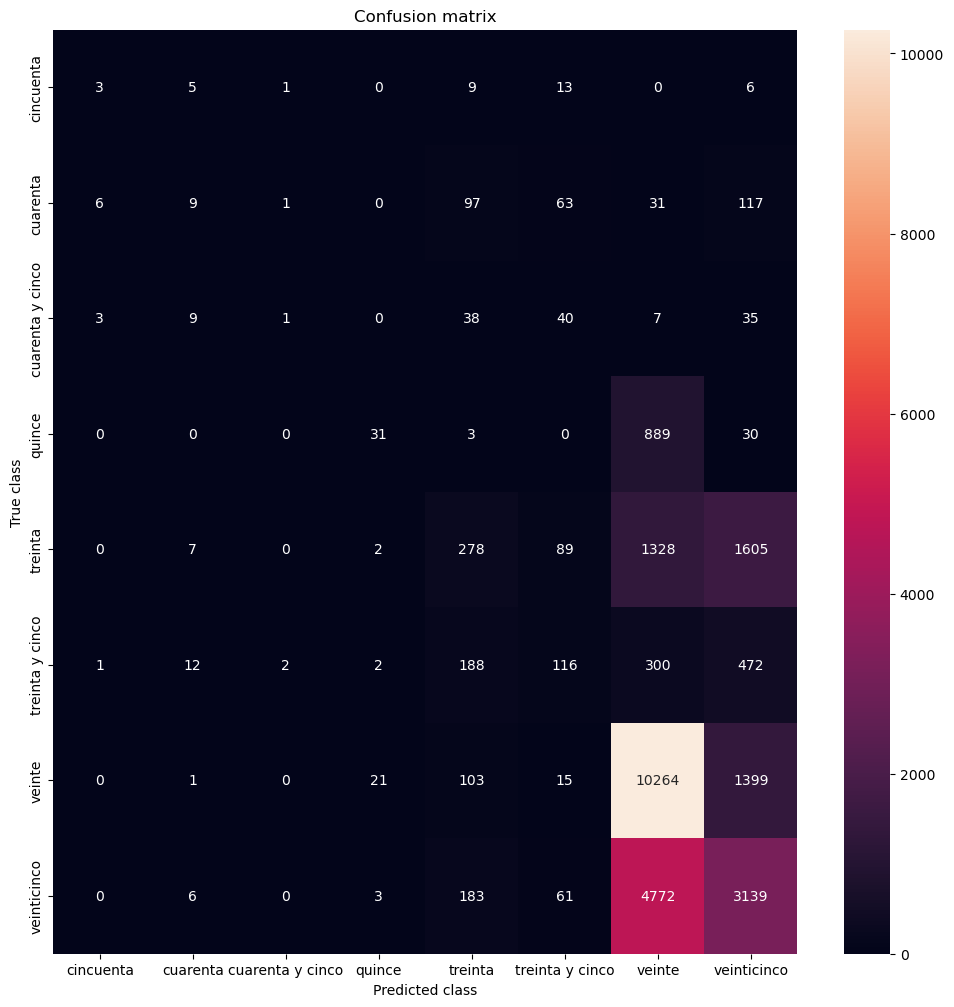

                  precision    recall  f1-score   support

       cincuenta       0.23      0.08      0.12        37
        cuarenta       0.18      0.03      0.05       324
cuarenta y cinco       0.20      0.01      0.01       133
          quince       0.53      0.03      0.06       953
         treinta       0.31      0.08      0.13      3309
 treinta y cinco       0.29      0.11      0.16      1093
          veinte       0.58      0.87      0.70     11803
     veinticinco       0.46      0.38      0.42      8164

        accuracy                           0.54     25816
       macro avg       0.35      0.20      0.21     25816
    weighted avg       0.49      0.54      0.48     25816

Ejecutando modelo con balanceo


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


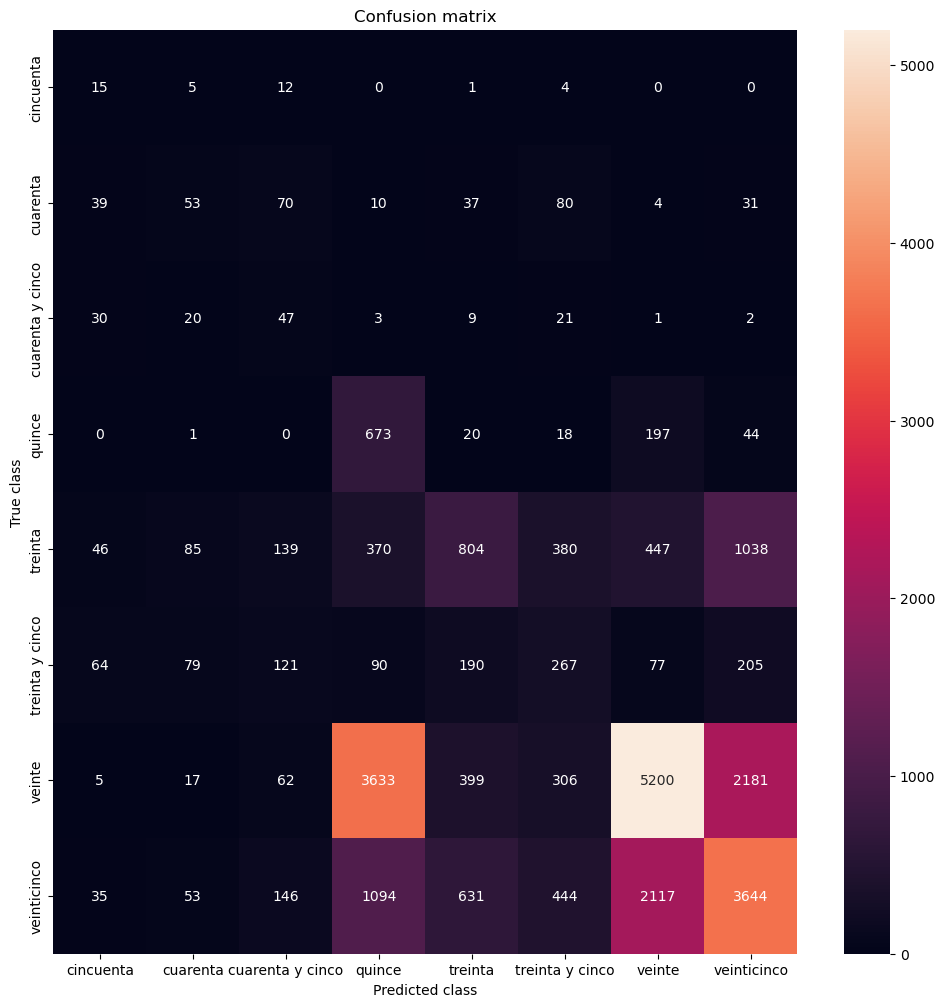

                  precision    recall  f1-score   support

       cincuenta       0.06      0.41      0.11        37
        cuarenta       0.17      0.16      0.17       324
cuarenta y cinco       0.08      0.35      0.13       133
          quince       0.11      0.71      0.20       953
         treinta       0.38      0.24      0.30      3309
 treinta y cinco       0.18      0.24      0.20      1093
          veinte       0.65      0.44      0.52     11803
     veinticinco       0.51      0.45      0.48      8164

        accuracy                           0.41     25816
       macro avg       0.27      0.38      0.26     25816
    weighted avg       0.52      0.41      0.45     25816

Ejecutando modelo con undersampling NearMiss


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


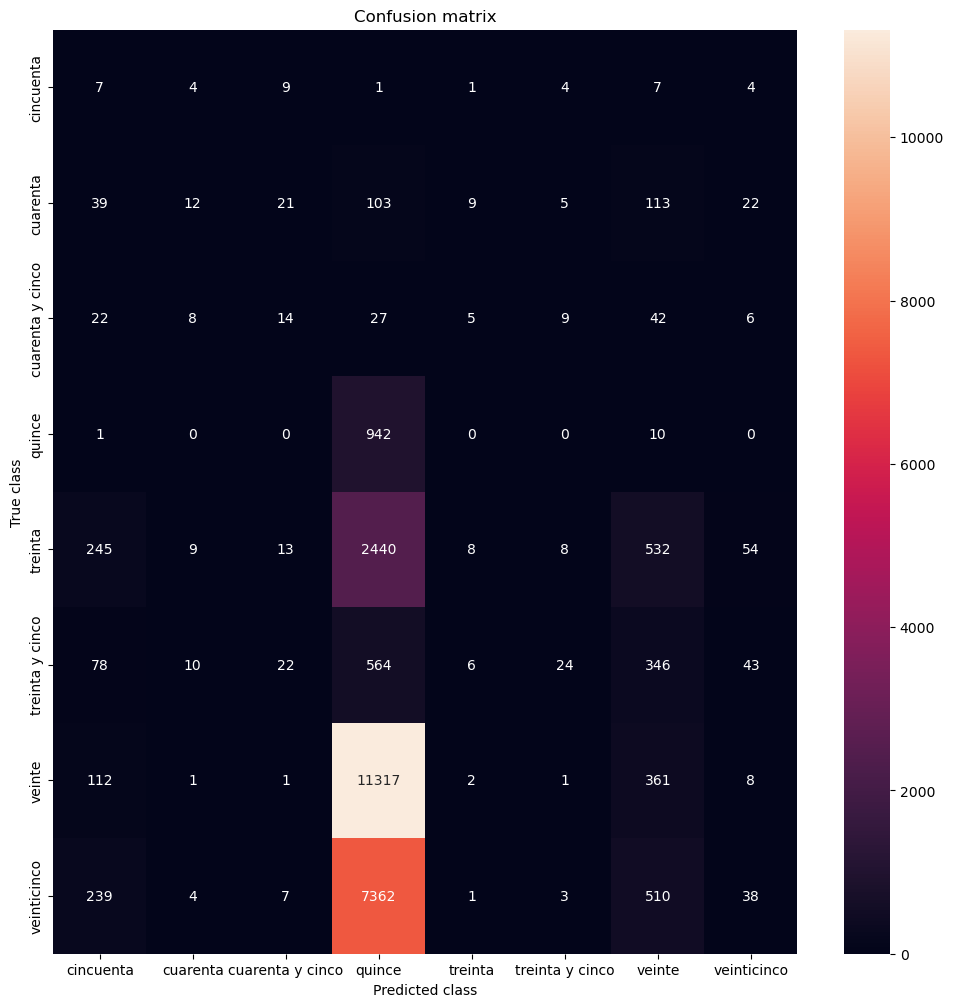

                  precision    recall  f1-score   support

       cincuenta       0.01      0.19      0.02        37
        cuarenta       0.25      0.04      0.06       324
cuarenta y cinco       0.16      0.11      0.13       133
          quince       0.04      0.99      0.08       953
         treinta       0.25      0.00      0.00      3309
 treinta y cinco       0.44      0.02      0.04      1093
          veinte       0.19      0.03      0.05     11803
     veinticinco       0.22      0.00      0.01      8164

        accuracy                           0.05     25816
       macro avg       0.20      0.17      0.05     25816
    weighted avg       0.21      0.05      0.03     25816

Ejecutando modelo con SMOTE
Distribution before resampling Counter({'veinte': 27990, 'veinticinco': 18738, 'treinta': 7587, 'treinta y cinco': 2621, 'quince': 2237, 'cuarenta': 743, 'cuarenta y cinco': 217, 'cincuenta': 101})
Distribution after resampling Counter({'veinticinco': 27990, 'veinte': 2799

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


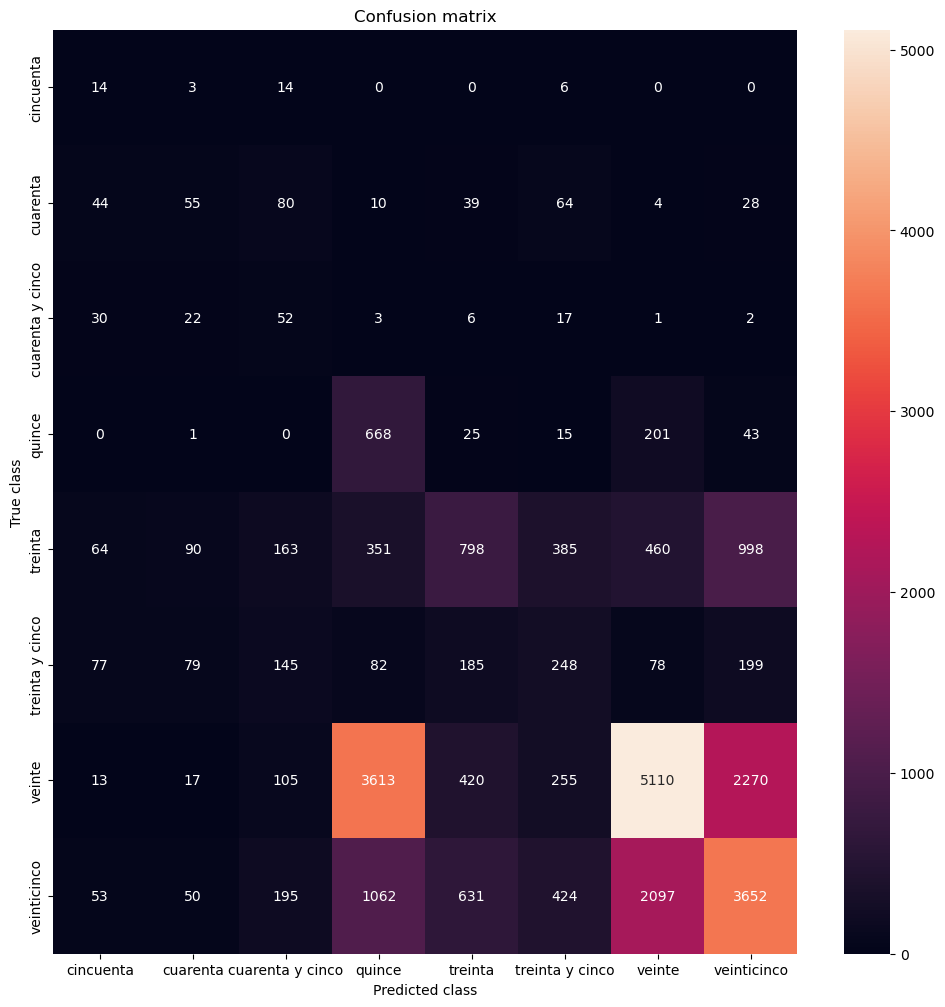

                  precision    recall  f1-score   support

       cincuenta       0.05      0.38      0.08        37
        cuarenta       0.17      0.17      0.17       324
cuarenta y cinco       0.07      0.39      0.12       133
          quince       0.12      0.70      0.20       953
         treinta       0.38      0.24      0.29      3309
 treinta y cinco       0.18      0.23      0.20      1093
          veinte       0.64      0.43      0.52     11803
     veinticinco       0.51      0.45      0.48      8164

        accuracy                           0.41     25816
       macro avg       0.26      0.37      0.26     25816
    weighted avg       0.52      0.41      0.44     25816

Ejecutando modelo con Balanced Bagging Classifier


C:\Users\ASUS\anaconda3\lib\site-packages\imblearn\ensemble\_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


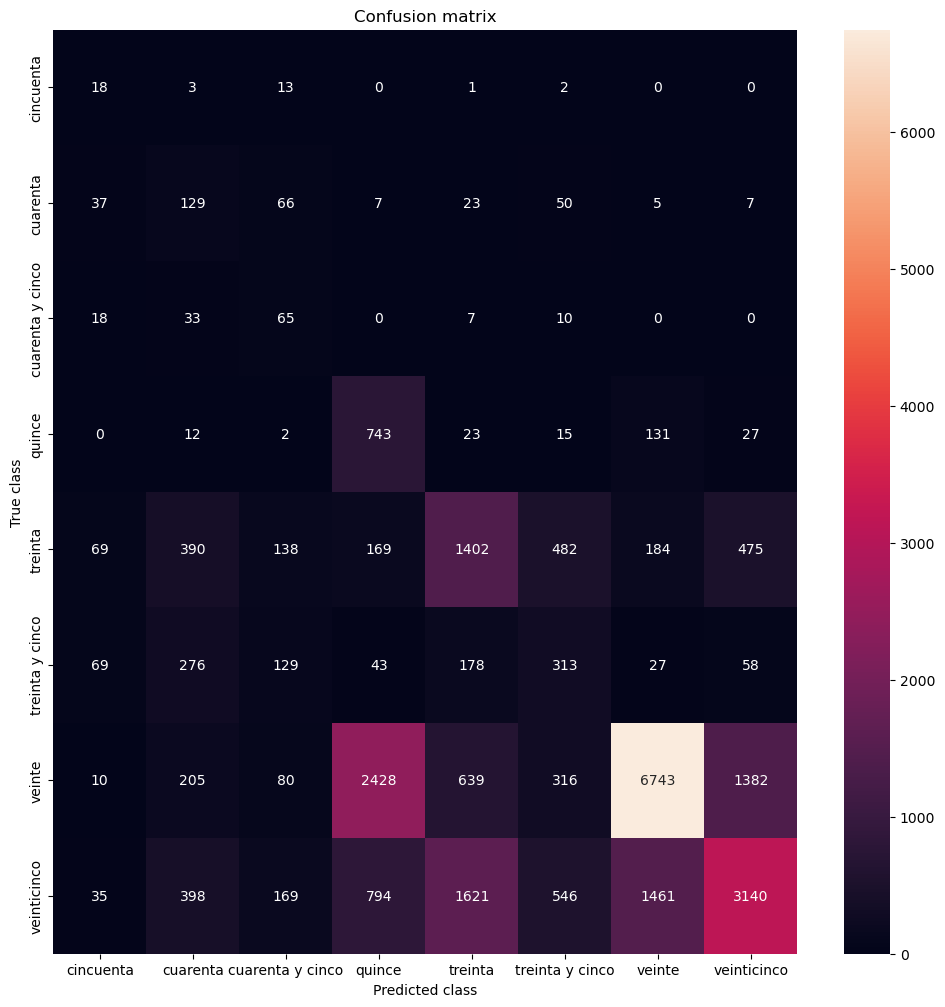

                  precision    recall  f1-score   support

       cincuenta       0.07      0.49      0.12        37
        cuarenta       0.09      0.40      0.15       324
cuarenta y cinco       0.10      0.49      0.16       133
          quince       0.18      0.78      0.29       953
         treinta       0.36      0.42      0.39      3309
 treinta y cinco       0.18      0.29      0.22      1093
          veinte       0.79      0.57      0.66     11803
     veinticinco       0.62      0.38      0.47      8164

        accuracy                           0.49     25816
       macro avg       0.30      0.48      0.31     25816
    weighted avg       0.62      0.49      0.53     25816

Trabajando con el dataframe número 2
Ejecutando modelo sin balanceo


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


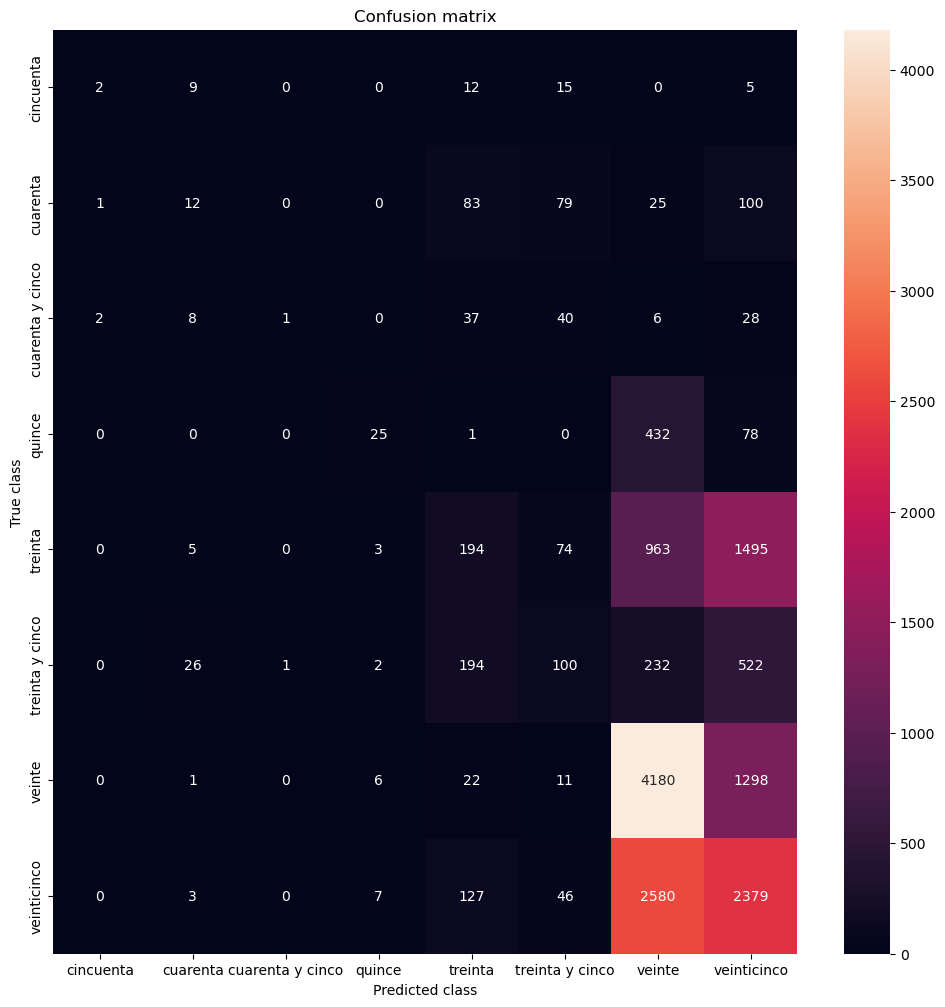

                  precision    recall  f1-score   support

       cincuenta       0.40      0.05      0.08        43
        cuarenta       0.19      0.04      0.07       300
cuarenta y cinco       0.50      0.01      0.02       122
          quince       0.58      0.05      0.09       536
         treinta       0.29      0.07      0.11      2734
 treinta y cinco       0.27      0.09      0.14      1077
          veinte       0.50      0.76      0.60      5518
     veinticinco       0.40      0.46      0.43      5142

        accuracy                           0.45     15472
       macro avg       0.39      0.19      0.19     15472
    weighted avg       0.41      0.45      0.39     15472

Ejecutando modelo con balanceo


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


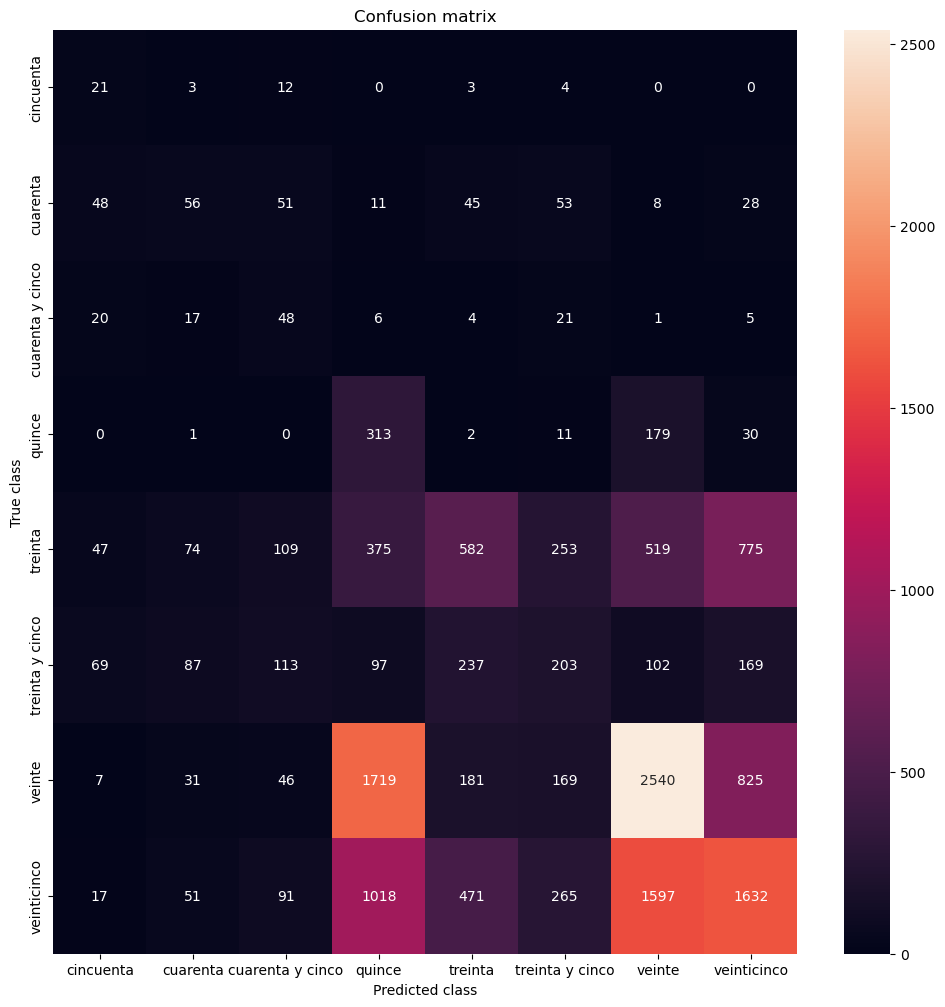

                  precision    recall  f1-score   support

       cincuenta       0.09      0.49      0.15        43
        cuarenta       0.17      0.19      0.18       300
cuarenta y cinco       0.10      0.39      0.16       122
          quince       0.09      0.58      0.15       536
         treinta       0.38      0.21      0.27      2734
 treinta y cinco       0.21      0.19      0.20      1077
          veinte       0.51      0.46      0.49      5518
     veinticinco       0.47      0.32      0.38      5142

        accuracy                           0.35     15472
       macro avg       0.25      0.35      0.25     15472
    weighted avg       0.43      0.35      0.37     15472

Ejecutando modelo con undersampling NearMiss


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


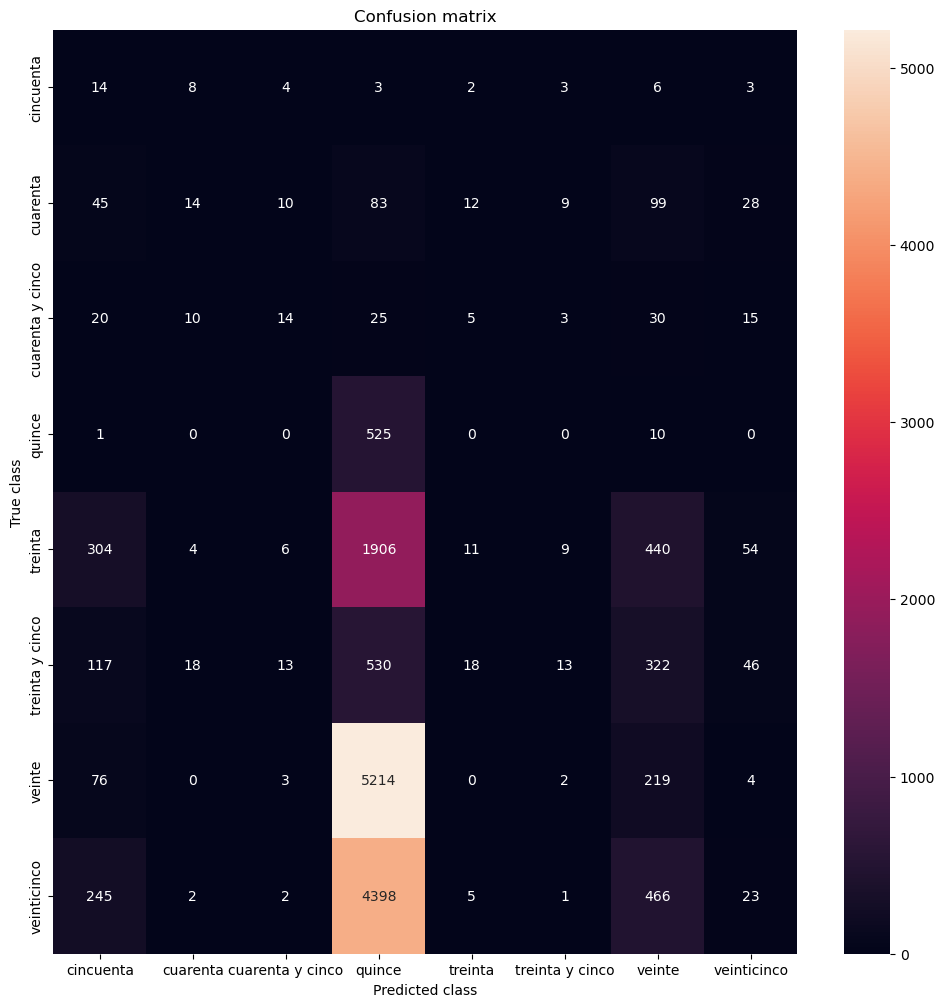

                  precision    recall  f1-score   support

       cincuenta       0.02      0.33      0.03        43
        cuarenta       0.25      0.05      0.08       300
cuarenta y cinco       0.27      0.11      0.16       122
          quince       0.04      0.98      0.08       536
         treinta       0.21      0.00      0.01      2734
 treinta y cinco       0.33      0.01      0.02      1077
          veinte       0.14      0.04      0.06      5518
     veinticinco       0.13      0.00      0.01      5142

        accuracy                           0.05     15472
       macro avg       0.17      0.19      0.06     15472
    weighted avg       0.16      0.05      0.03     15472

Ejecutando modelo con SMOTE
Distribution before resampling Counter({'veinte': 12791, 'veinticinco': 11849, 'treinta': 6443, 'treinta y cinco': 2633, 'quince': 1295, 'cuarenta': 767, 'cuarenta y cinco': 228, 'cincuenta': 95})
Distribution after resampling Counter({'quince': 12791, 'veinte': 12791, 've

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


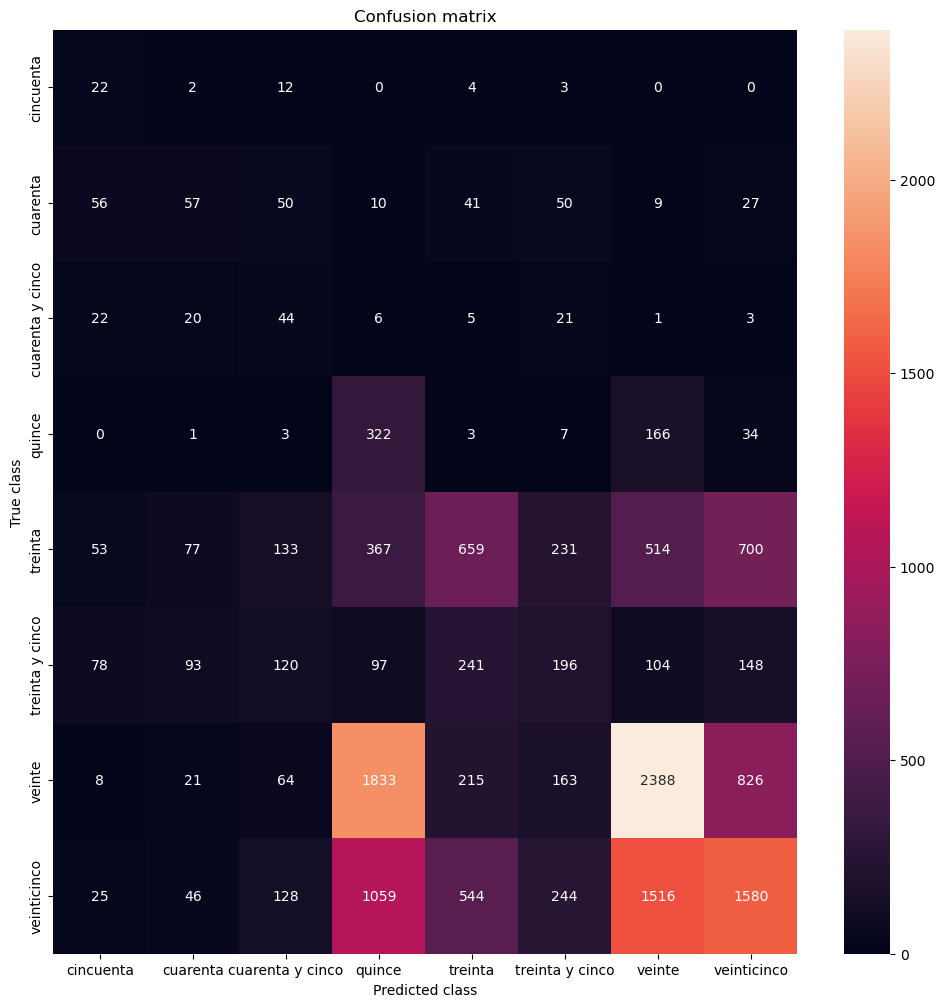

                  precision    recall  f1-score   support

       cincuenta       0.08      0.51      0.14        43
        cuarenta       0.18      0.19      0.18       300
cuarenta y cinco       0.08      0.36      0.13       122
          quince       0.09      0.60      0.15       536
         treinta       0.38      0.24      0.30      2734
 treinta y cinco       0.21      0.18      0.20      1077
          veinte       0.51      0.43      0.47      5518
     veinticinco       0.48      0.31      0.37      5142

        accuracy                           0.34     15472
       macro avg       0.25      0.35      0.24     15472
    weighted avg       0.43      0.34      0.37     15472

Ejecutando modelo con Balanced Bagging Classifier


C:\Users\ASUS\anaconda3\lib\site-packages\imblearn\ensemble\_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


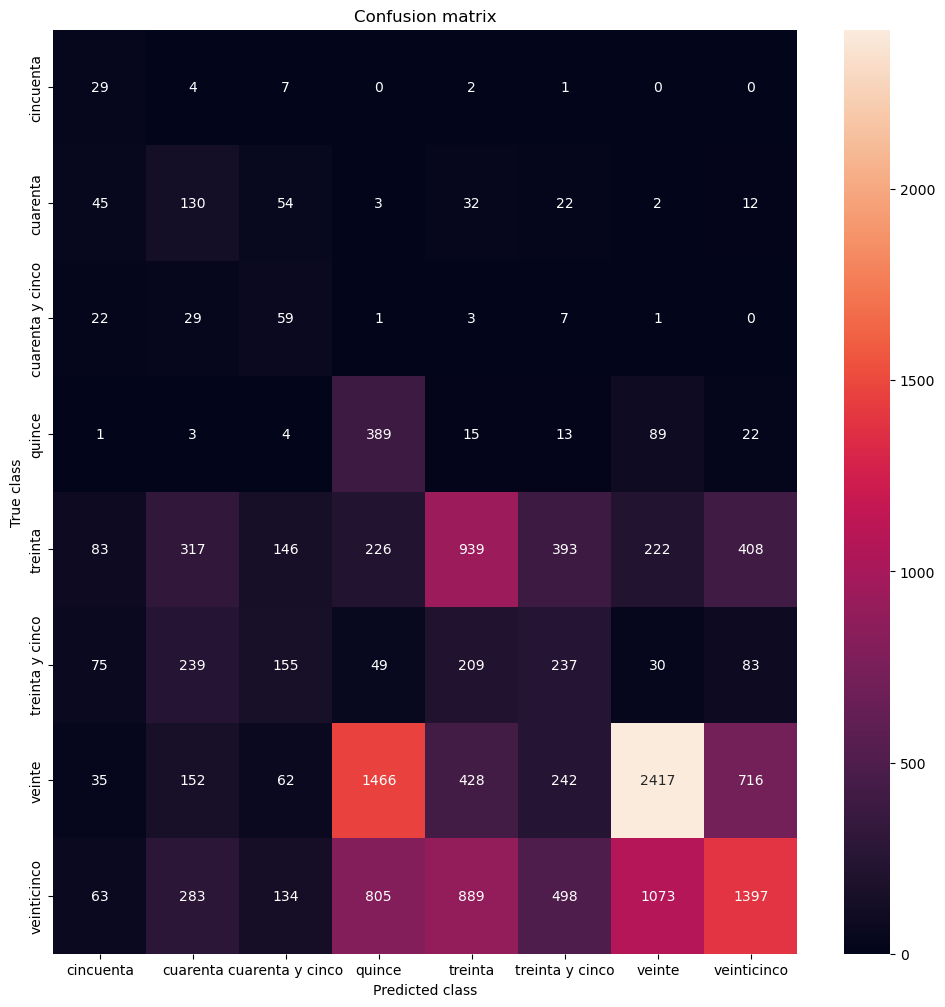

                  precision    recall  f1-score   support

       cincuenta       0.08      0.67      0.15        43
        cuarenta       0.11      0.43      0.18       300
cuarenta y cinco       0.10      0.48      0.16       122
          quince       0.13      0.73      0.22       536
         treinta       0.37      0.34      0.36      2734
 treinta y cinco       0.17      0.22      0.19      1077
          veinte       0.63      0.44      0.52      5518
     veinticinco       0.53      0.27      0.36      5142

        accuracy                           0.36     15472
       macro avg       0.27      0.45      0.27     15472
    weighted avg       0.49      0.36      0.39     15472

Trabajando con el dataframe número 3
Ejecutando modelo sin balanceo


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


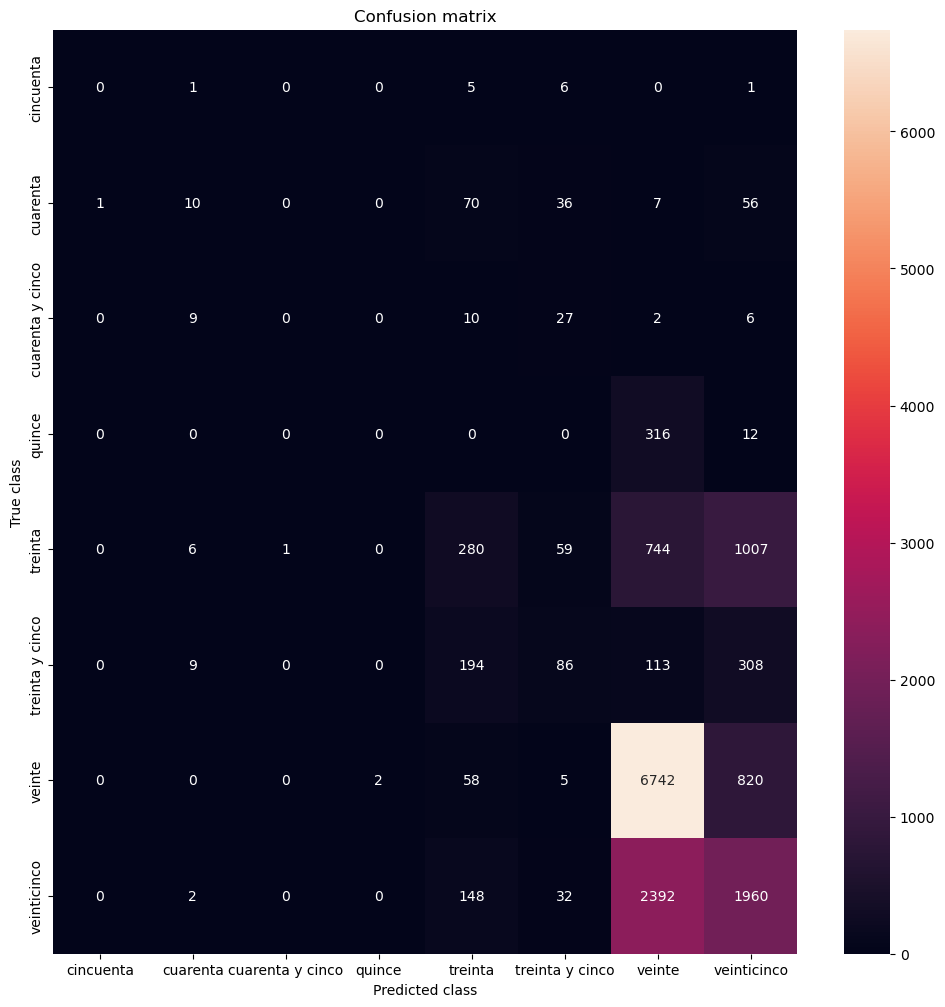

                  precision    recall  f1-score   support

       cincuenta       0.00      0.00      0.00        13
        cuarenta       0.27      0.06      0.09       180
cuarenta y cinco       0.00      0.00      0.00        54
          quince       0.00      0.00      0.00       328
         treinta       0.37      0.13      0.20      2097
 treinta y cinco       0.34      0.12      0.18       710
          veinte       0.65      0.88      0.75      7627
     veinticinco       0.47      0.43      0.45      4534

        accuracy                           0.58     15543
       macro avg       0.26      0.20      0.21     15543
    weighted avg       0.53      0.58      0.54     15543

Ejecutando modelo con balanceo


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


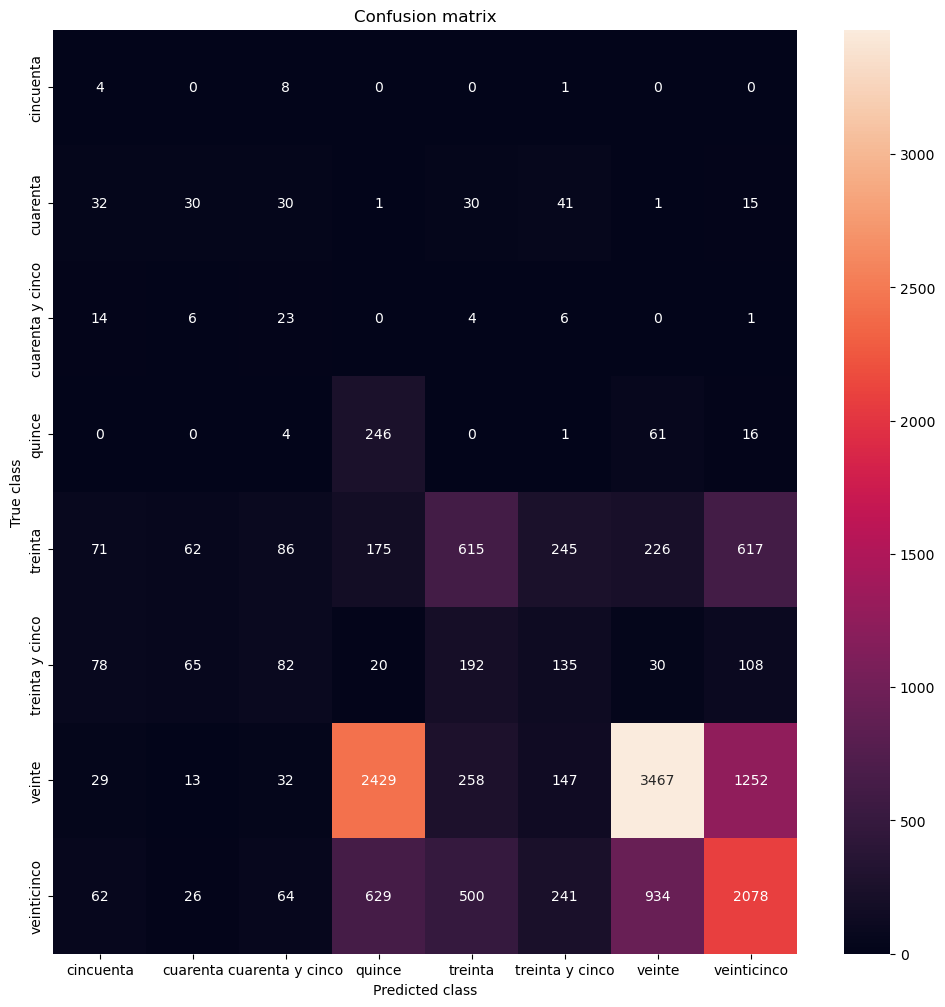

                  precision    recall  f1-score   support

       cincuenta       0.01      0.31      0.03        13
        cuarenta       0.15      0.17      0.16       180
cuarenta y cinco       0.07      0.43      0.12        54
          quince       0.07      0.75      0.13       328
         treinta       0.38      0.29      0.33      2097
 treinta y cinco       0.17      0.19      0.18       710
          veinte       0.73      0.45      0.56      7627
     veinticinco       0.51      0.46      0.48      4534

        accuracy                           0.42     15543
       macro avg       0.26      0.38      0.25     15543
    weighted avg       0.57      0.42      0.47     15543

Ejecutando modelo con undersampling NearMiss


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


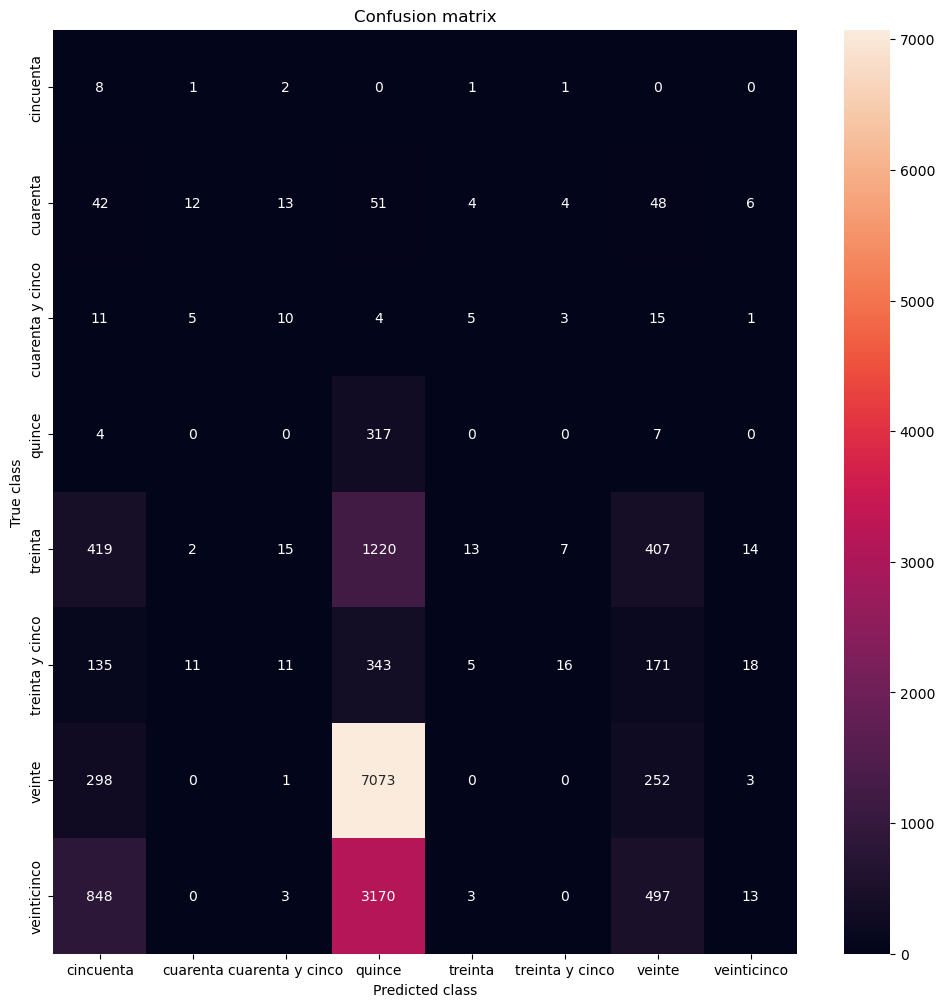

                  precision    recall  f1-score   support

       cincuenta       0.00      0.62      0.01        13
        cuarenta       0.39      0.07      0.11       180
cuarenta y cinco       0.18      0.19      0.18        54
          quince       0.03      0.97      0.05       328
         treinta       0.42      0.01      0.01      2097
 treinta y cinco       0.52      0.02      0.04       710
          veinte       0.18      0.03      0.06      7627
     veinticinco       0.24      0.00      0.01      4534

        accuracy                           0.04     15543
       macro avg       0.24      0.24      0.06     15543
    weighted avg       0.24      0.04      0.04     15543

Ejecutando modelo con SMOTE
Distribution before resampling Counter({'veinte': 17757, 'veinticinco': 10611, 'treinta': 4753, 'treinta y cinco': 1740, 'quince': 764, 'cuarenta': 505, 'cuarenta y cinco': 96, 'cincuenta': 39})
Distribution after resampling Counter({'veinte': 17757, 'treinta': 17757, 'vei

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


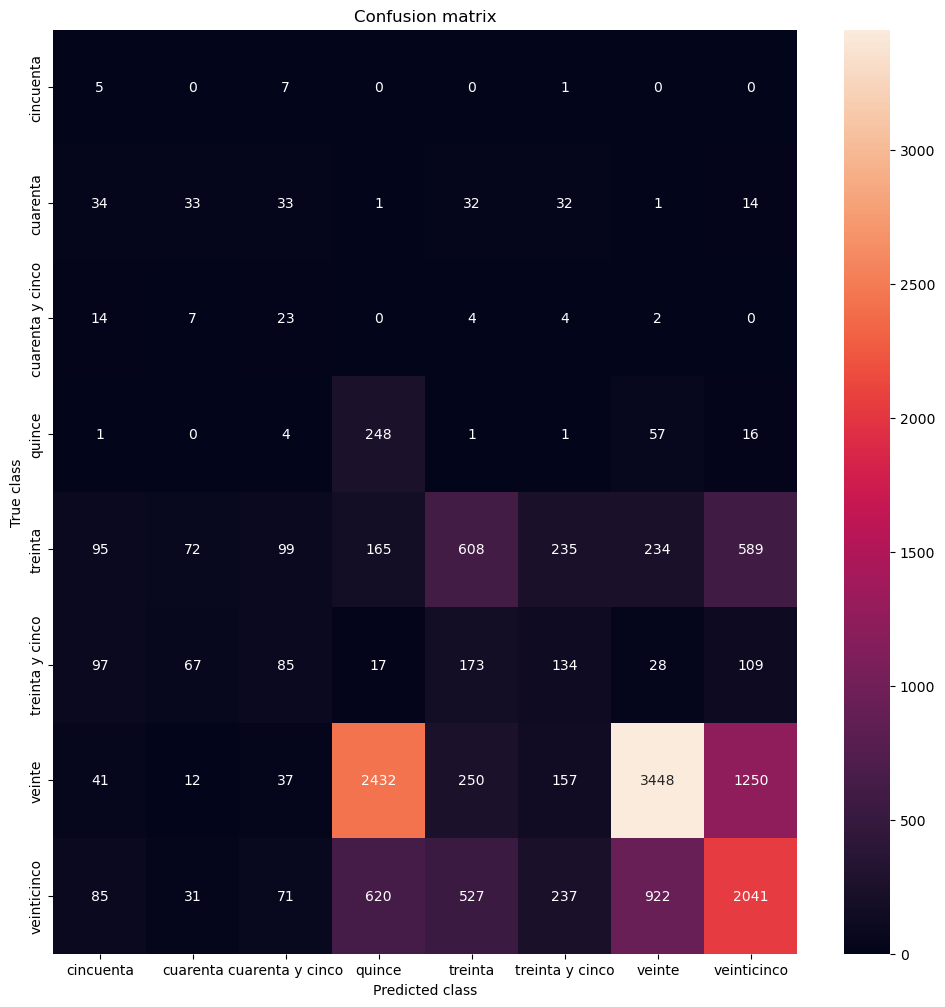

                  precision    recall  f1-score   support

       cincuenta       0.01      0.38      0.03        13
        cuarenta       0.15      0.18      0.16       180
cuarenta y cinco       0.06      0.43      0.11        54
          quince       0.07      0.76      0.13       328
         treinta       0.38      0.29      0.33      2097
 treinta y cinco       0.17      0.19      0.18       710
          veinte       0.73      0.45      0.56      7627
     veinticinco       0.51      0.45      0.48      4534

        accuracy                           0.42     15543
       macro avg       0.26      0.39      0.25     15543
    weighted avg       0.57      0.42      0.47     15543

Ejecutando modelo con Balanced Bagging Classifier


C:\Users\ASUS\anaconda3\lib\site-packages\imblearn\ensemble\_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


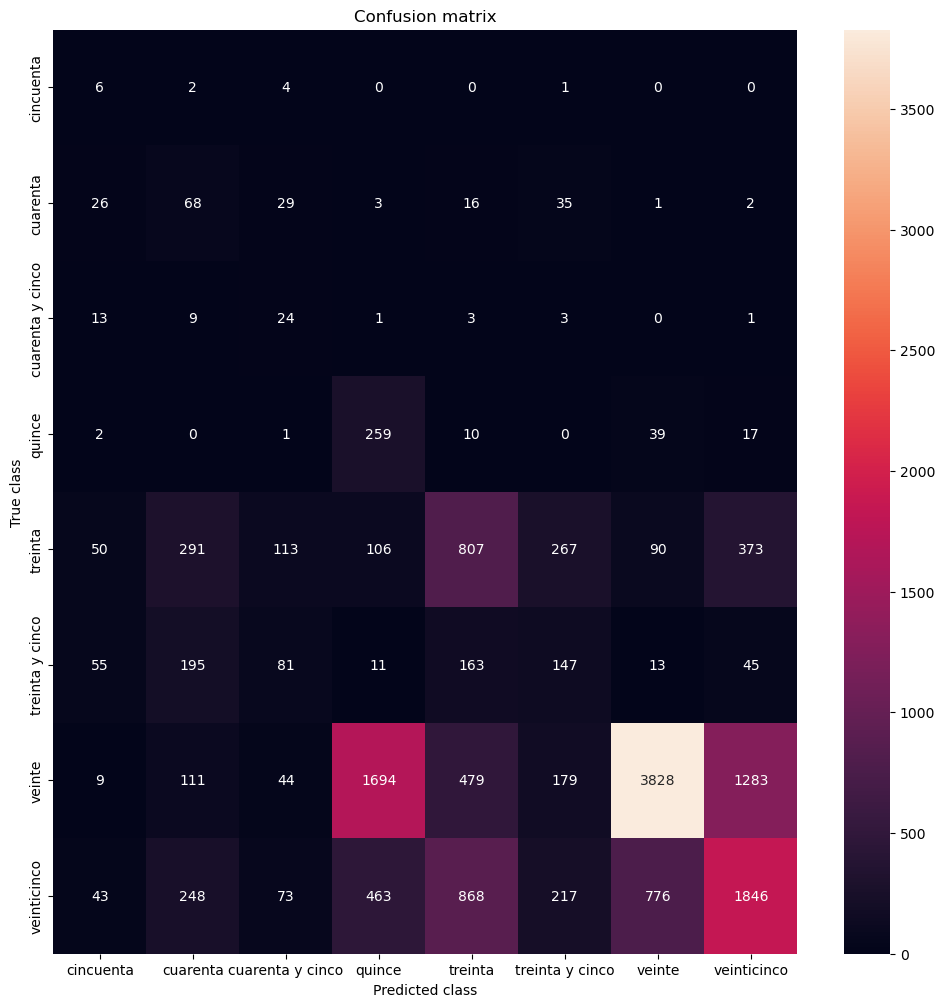

                  precision    recall  f1-score   support

       cincuenta       0.03      0.46      0.06        13
        cuarenta       0.07      0.38      0.12       180
cuarenta y cinco       0.07      0.44      0.11        54
          quince       0.10      0.79      0.18       328
         treinta       0.34      0.38      0.36      2097
 treinta y cinco       0.17      0.21      0.19       710
          veinte       0.81      0.50      0.62      7627
     veinticinco       0.52      0.41      0.46      4534

        accuracy                           0.45     15543
       macro avg       0.26      0.45      0.26     15543
    weighted avg       0.60      0.45      0.50     15543

Trabajando con el dataframe número 4
Ejecutando modelo sin balanceo


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


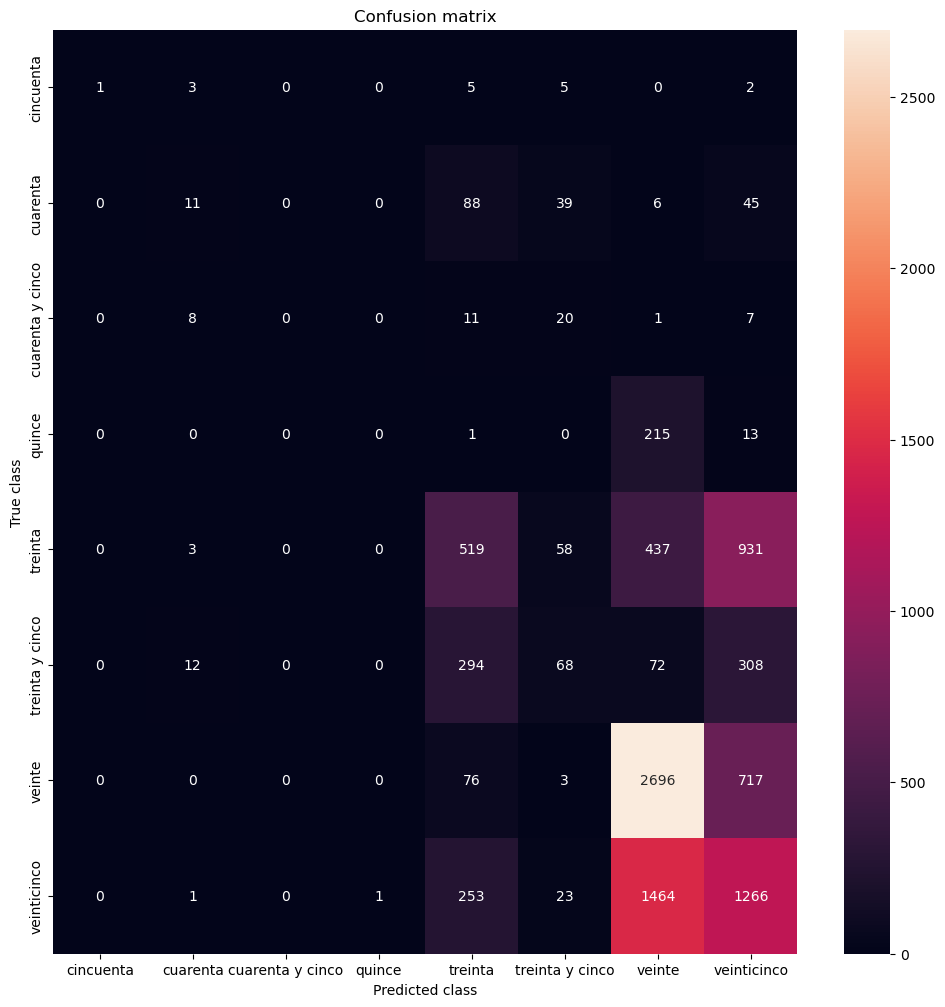

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

       cincuenta       1.00      0.06      0.12        16
        cuarenta       0.29      0.06      0.10       189
cuarenta y cinco       0.00      0.00      0.00        47
          quince       0.00      0.00      0.00       229
         treinta       0.42      0.27      0.32      1948
 treinta y cinco       0.31      0.09      0.14       754
          veinte       0.55      0.77      0.64      3492
     veinticinco       0.38      0.42      0.40      3008

        accuracy                           0.47      9683
       macro avg       0.37      0.21      0.22      9683
    weighted avg       0.43      0.47      0.44      9683

Ejecutando modelo con balanceo


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


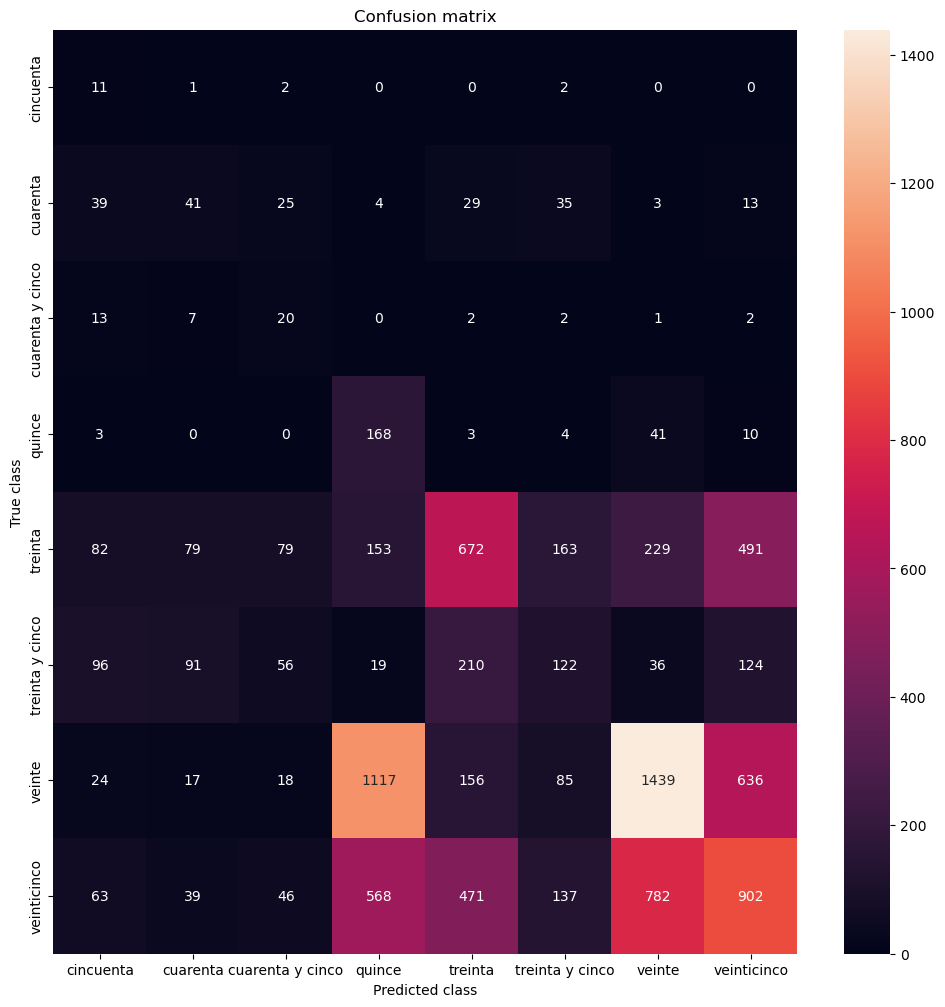

                  precision    recall  f1-score   support

       cincuenta       0.03      0.69      0.06        16
        cuarenta       0.15      0.22      0.18       189
cuarenta y cinco       0.08      0.43      0.14        47
          quince       0.08      0.73      0.15       229
         treinta       0.44      0.34      0.38      1948
 treinta y cinco       0.22      0.16      0.19       754
          veinte       0.57      0.41      0.48      3492
     veinticinco       0.41      0.30      0.35      3008

        accuracy                           0.35      9683
       macro avg       0.25      0.41      0.24      9683
    weighted avg       0.44      0.35      0.38      9683

Ejecutando modelo con undersampling NearMiss


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


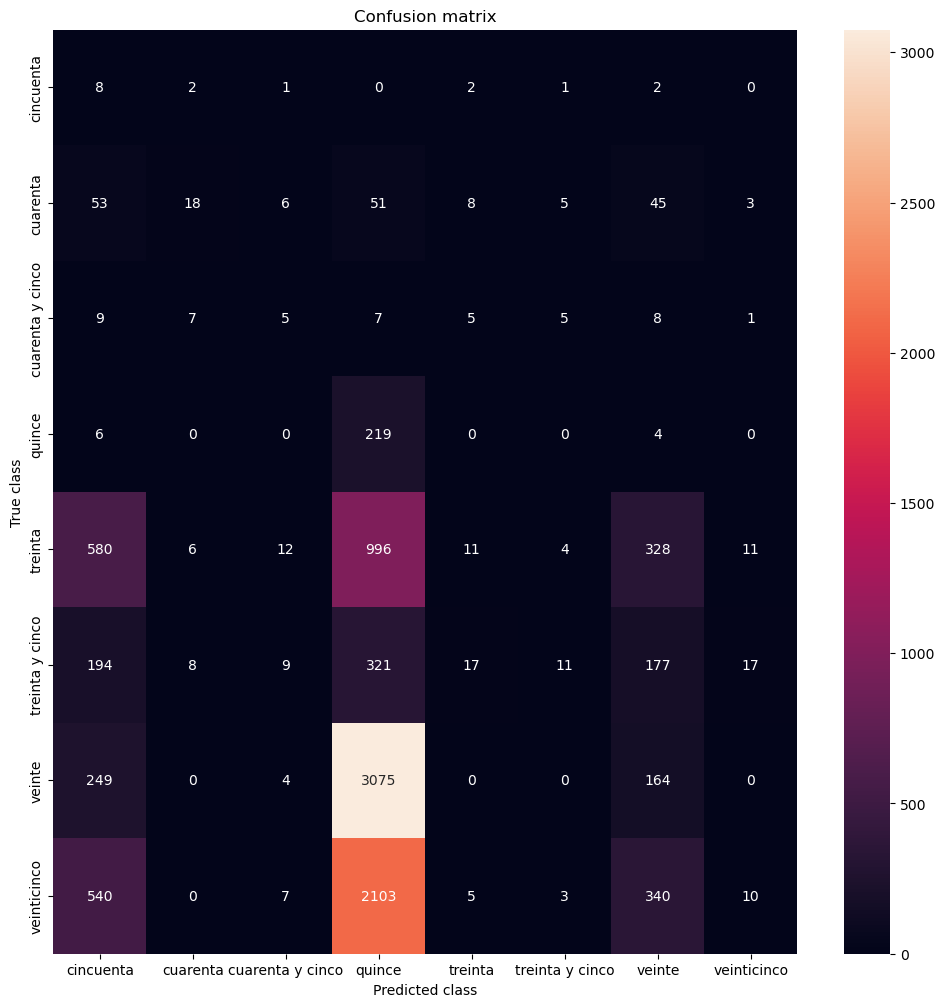

                  precision    recall  f1-score   support

       cincuenta       0.00      0.50      0.01        16
        cuarenta       0.44      0.10      0.16       189
cuarenta y cinco       0.11      0.11      0.11        47
          quince       0.03      0.96      0.06       229
         treinta       0.23      0.01      0.01      1948
 treinta y cinco       0.38      0.01      0.03       754
          veinte       0.15      0.05      0.07      3492
     veinticinco       0.24      0.00      0.01      3008

        accuracy                           0.05      9683
       macro avg       0.20      0.22      0.06      9683
    weighted avg       0.21      0.05      0.04      9683

Ejecutando modelo con SMOTE
Distribution before resampling Counter({'veinte': 8169, 'veinticinco': 7153, 'treinta': 4456, 'treinta y cinco': 1695, 'cuarenta': 496, 'quince': 483, 'cuarenta y cinco': 103, 'cincuenta': 36})
Distribution after resampling Counter({'treinta': 8169, 'veinte': 8169, 'cincue

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


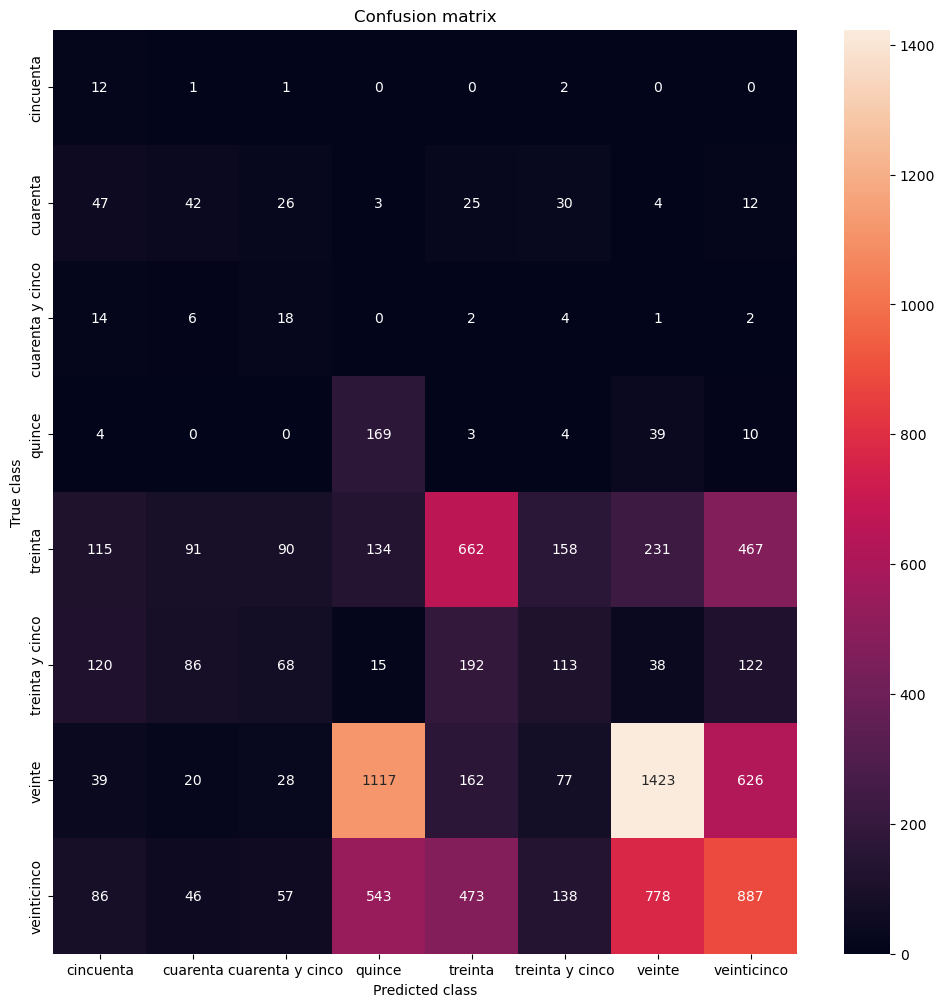

                  precision    recall  f1-score   support

       cincuenta       0.03      0.75      0.05        16
        cuarenta       0.14      0.22      0.17       189
cuarenta y cinco       0.06      0.38      0.11        47
          quince       0.09      0.74      0.15       229
         treinta       0.44      0.34      0.38      1948
 treinta y cinco       0.21      0.15      0.18       754
          veinte       0.57      0.41      0.47      3492
     veinticinco       0.42      0.29      0.35      3008

        accuracy                           0.34      9683
       macro avg       0.24      0.41      0.23      9683
    weighted avg       0.44      0.34      0.38      9683

Ejecutando modelo con Balanced Bagging Classifier


C:\Users\ASUS\anaconda3\lib\site-packages\imblearn\ensemble\_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


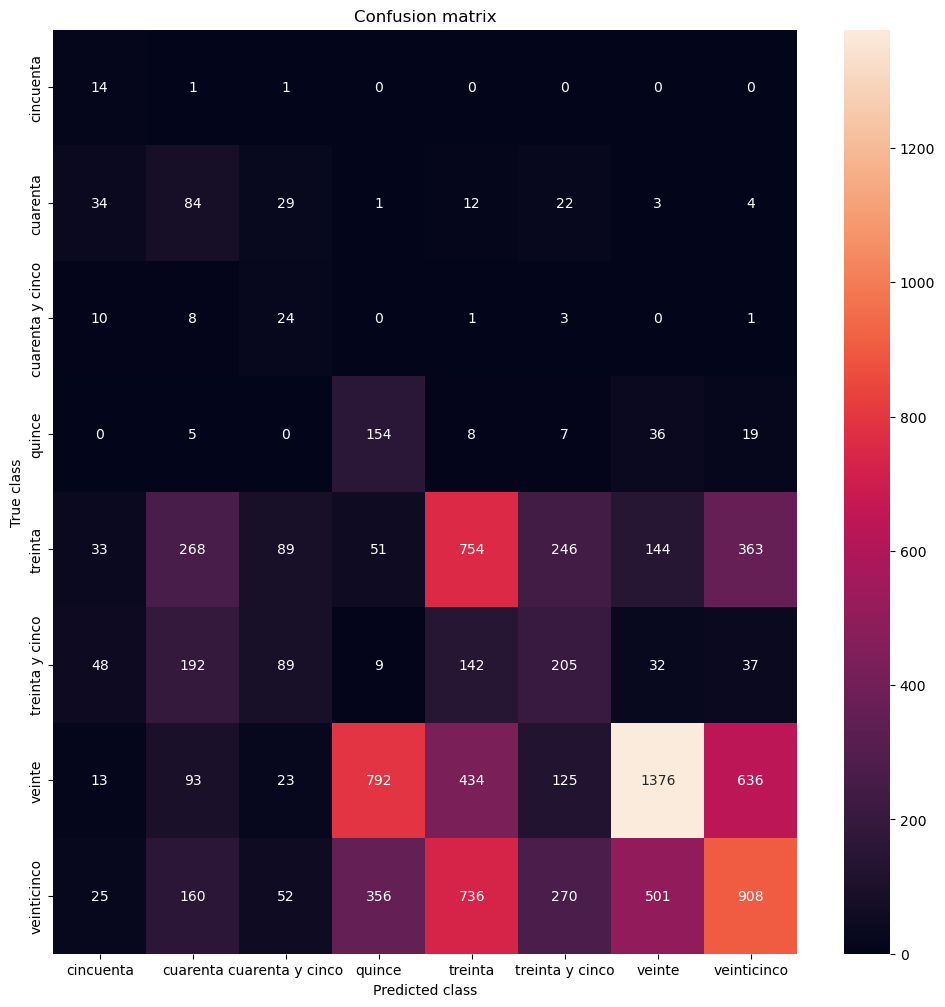

                  precision    recall  f1-score   support

       cincuenta       0.08      0.88      0.15        16
        cuarenta       0.10      0.44      0.17       189
cuarenta y cinco       0.08      0.51      0.14        47
          quince       0.11      0.67      0.19       229
         treinta       0.36      0.39      0.37      1948
 treinta y cinco       0.23      0.27      0.25       754
          veinte       0.66      0.39      0.49      3492
     veinticinco       0.46      0.30      0.36      3008

        accuracy                           0.36      9683
       macro avg       0.26      0.48      0.27      9683
    weighted avg       0.48      0.36      0.39      9683



In [18]:
dataframes = [df_category, df_edit_category, df_2017_category, df_edit_2017_category]
run_analysis(dataframes)

### DATAFRAME COMPLETO

**Sin balanceo**

1. Precision: La precisión indica la proporción de instancias positivas que fueron correctamente clasificadas. En este caso, las categorías "veinte" y "veinticinco" tienen una alta precisión, lo que sugiere que el modelo tiene un buen rendimiento al predecir estas categorías. Por otro lado, las categorías "cincuenta", "cuarenta", "cuarenta y cinco", "quince", "treinta" y "treinta y cinco" tienen una precisión más baja, lo que indica que el modelo tiene dificultades para clasificar correctamente estas categorías.

2. Recall: El recall (también conocido como sensibilidad) representa la proporción de instancias positivas que fueron correctamente identificadas por el modelo. Al observar los valores de recall, se puede ver que la mayoría de las categorías tienen valores bajos. Esto indica que el modelo tiene dificultades para identificar correctamente las instancias positivas en general.

3. F1-score: El F1-score es una medida que combina la precisión y el recall en una sola métrica. En general, las categorías con F1-scores más altos son "veinte" y "veinticinco", lo que indica que el modelo logra un mejor equilibrio entre la precisión y el recall en estas categorías. Las categorías con F1-scores más bajos son "cuarenta", "cuarenta y cinco" y "quince", lo que sugiere que el modelo tiene dificultades para lograr un equilibrio entre la precisión y el recall en estas categorías.

4. Support: El "support" muestra el número de instancias en cada categoría. Puede ayudar a identificar las categorías que tienen un mayor número de ejemplos en el conjunto de datos.

5. Accuracy: La precisión general del modelo es del 54%, lo que indica que el modelo clasifica correctamente alrededor del 54% de las instancias en general. Sin embargo, dado que las categorías tienen desequilibrios en términos de soporte, la precisión general puede no ser una medida completa del rendimiento del modelo.

6. Macro avg: Esta fila muestra los promedios de precision, recall y F1-score para todas las categorías. La precisión promedio es del 35%, el recall promedio es del 20% y el F1-score promedio es del 21%. Estos valores indican un rendimiento general bajo del modelo.

7. Weighted avg: Esta fila muestra los promedios ponderados de precision, recall y F1-score, donde se considera el soporte de cada categoría. La precisión ponderada es del 49%, el recall ponderado es del 54% y el F1-score ponderado es del 48%. Estos valores indican que el rendimiento del modelo está influenciado por las categorías con mayor soporte, como "veinte" y "veinticinco".

En general, estos resultados sugieren que el modelo tiene dificultades para clasificar correctamente las categorías minoritarias y tiende a tener un mejor rendimiento en las categorías con mayor soporte. Sería útil investigar y abordar las razones detrás de las bajas precisiones y recalls en las categorías minoritarias para mejorar el rendimiento general del modelo. Además, podrían considerarse técnicas de equilibrio de clase o recopilar más datos para las categorías menos representadas.

**Con penalización de regresión logística**

1. Precision: La precisión sigue siendo baja en general, pero se observa una mejora en comparación con los resultados anteriores. Las categorías "veinte" y "veinticinco" tienen una precisión relativamente alta, lo que indica que el modelo logra clasificar correctamente la mayoría de las instancias positivas en estas categorías. Sin embargo, la precisión sigue siendo baja para las categorías minoritarias como "cincuenta", "cuarenta", "cuarenta y cinco", "quince", "treinta" y "treinta y cinco".

2. Recall: El recall ha mejorado significativamente para la mayoría de las categorías en comparación con los resultados anteriores. Esto sugiere que el modelo ahora puede identificar mejor las instancias positivas en las categorías minoritarias. Las categorías "quince" y "cincuenta" tienen los valores más altos de recall, lo que indica que el modelo es capaz de identificar correctamente la mayoría de las instancias positivas en estas categorías.

3. F1-score: El F1-score también ha mejorado en comparación con los resultados anteriores. Las categorías "veinte" y "veinticinco" siguen teniendo los puntajes más altos de F1-score, lo que indica un buen equilibrio entre la precisión y el recall en estas categorías. Sin embargo, las categorías minoritarias todavía tienen puntajes bajos de F1-score, lo que sugiere que el modelo tiene dificultades para lograr un equilibrio en estas categorías.

4. Support: El "support" muestra el número de instancias en cada categoría, y sigue siendo el mismo que en los resultados anteriores.

5. Accuracy: La precisión general del modelo ha disminuido en comparación con los resultados anteriores, alcanzando ahora el 41%. Esto puede deberse a que el modelo penaliza más los errores en las categorías minoritarias, lo que resulta en una disminución en la precisión general.

6. Macro avg: La precisión promedio, el recall promedio y el F1-score promedio han mejorado en comparación con los resultados anteriores. Aunque siguen siendo relativamente bajos, esto indica una mejora en el rendimiento general del modelo.

7. Weighted avg: La precisión ponderada, el recall ponderado y el F1-score ponderado también han mejorado en comparación con los resultados anteriores. Esto sugiere una mejora en el rendimiento general del modelo, especialmente considerando el desequilibrio de clases en el conjunto de datos.

En resumen, la introducción de la penalización en la regresión logística ha mejorado el rendimiento del modelo en términos de recall y F1-score, especialmente para las categorías minoritarias. Sin embargo, la precisión sigue siendo baja en general, y se pueden explorar otras técnicas o enfoques para mejorar aún más el rendimiento del modelo en todas las categorías.

**Con submuestreo NearMiss**

1. Precision: La precisión es extremadamente baja en todas las categorías, lo que indica que el modelo tiene dificultades para clasificar correctamente las instancias positivas. Las categorías "cuarenta" y "treinta" tienen las precisiones más altas, pero aún son muy bajas.

2. Recall: El recall es muy alto para la categoría "quince", lo que indica que el modelo identifica correctamente la mayoría de las instancias positivas en esa categoría. Sin embargo, para las demás categorías, el recall es muy bajo, lo que sugiere que el modelo no es capaz de identificar adecuadamente las instancias positivas.

3. F1-score: El F1-score es muy bajo en todas las categorías, lo que indica un mal equilibrio entre la precisión y el recall. Esto sugiere que el modelo no está clasificando correctamente las instancias positivas y está teniendo dificultades para lograr un equilibrio entre la precisión y el recall.

4. Support: El "support" muestra el número de instancias en cada categoría y sigue siendo el mismo que en los resultados anteriores.

5. Accuracy: La precisión general del modelo es extremadamente baja, alcanzando solo el 5%. Esto indica que el modelo clasifica correctamente solo el 5% de las instancias en general.

6. Macro avg: La precisión promedio, el recall promedio y el F1-score promedio son muy bajos, lo que indica un rendimiento general muy pobre del modelo.

7. Weighted avg: La precisión ponderada, el recall ponderado y el F1-score ponderado también son muy bajos, lo que refleja el bajo rendimiento general del modelo, especialmente considerando el desequilibrio de clases en el conjunto de datos.

En resumen, el submuestreo NearMiss utilizado en estos resultados no ha logrado mejorar el rendimiento del modelo. La baja precisión, recall y F1-score en todas las categorías sugieren que el modelo no está aprendiendo correctamente los patrones de las instancias positivas. Es posible que se requieran otras técnicas o enfoques para abordar el desequilibrio de clases y mejorar el rendimiento del modelo en este conjunto de datos.

**Con SMOTE**

1. Precision: La precisión sigue siendo baja en general, pero se observa una mejora en comparación con los resultados anteriores. Las categorías "veinte" y "veinticinco" tienen una precisión relativamente alta, lo que indica que el modelo logra clasificar correctamente la mayoría de las instancias positivas en estas categorías. Sin embargo, la precisión sigue siendo baja para las categorías minoritarias como "cincuenta", "cuarenta", "cuarenta y cinco", "quince", "treinta" y "treinta y cinco".

2. Recall: El recall ha mejorado en comparación con los resultados anteriores, especialmente para las categorías minoritarias. Esto sugiere que el modelo ahora puede identificar mejor las instancias positivas en estas categorías. La categoría "quince" tiene un recall alto, lo que indica que el modelo puede identificar correctamente la mayoría de las instancias positivas en esa categoría.

3. F1-score: El F1-score también ha mejorado en comparación con los resultados anteriores. Las categorías "veinte" y "veinticinco" siguen teniendo puntajes altos de F1-score, lo que indica un buen equilibrio entre la precisión y el recall en estas categorías. Sin embargo, las categorías minoritarias todavía tienen puntajes bajos de F1-score, lo que sugiere que el modelo tiene dificultades para lograr un equilibrio en estas categorías.

4. Support: El "support" muestra el número de instancias en cada categoría y sigue siendo el mismo que en los resultados anteriores.

5. Accuracy: La precisión general del modelo es del 41%, que es similar a los resultados anteriores. Esto indica que el modelo clasifica correctamente alrededor del 41% de las instancias en general.

6. Macro avg: La precisión promedio, el recall promedio y el F1-score promedio han mejorado en comparación con los resultados anteriores. Aunque siguen siendo relativamente bajos, esto indica una mejora en el rendimiento general del modelo.

7. Weighted avg: La precisión ponderada, el recall ponderado y el F1-score ponderado también han mejorado en comparación con los resultados anteriores. Esto sugiere una mejora en el rendimiento general del modelo, especialmente considerando el desequilibrio de clases en el conjunto de datos.

En resumen, el sobremuestreo SMOTE ha mejorado el rendimiento del modelo en términos de recall y F1-score, especialmente para las categorías minoritarias. Sin embargo, la precisión sigue siendo baja en general, y se pueden explorar otras técnicas o enfoques para mejorar aún más el rendimiento del modelo en todas las categorías.

**Con Balanced Bagging Classifier**

1. Precision: La precisión ha mejorado en comparación con los resultados anteriores. Aunque sigue siendo baja en algunas categorías, como "cincuenta", "cuarenta", "cuarenta y cinco" y "treinta y cinco", se observa una mejora en la mayoría de las categorías. Las categorías "veinte" y "veinticinco" tienen una precisión alta, lo que indica que el modelo clasifica correctamente la mayoría de las instancias positivas en estas categorías.

2. Recall: El recall también ha mejorado en comparación con los resultados anteriores. Se observa un aumento en el recall en la mayoría de las categorías, lo que indica que el modelo puede identificar mejor las instancias positivas. Las categorías "quince", "treinta" y "veinte" tienen valores de recall relativamente altos.

3. F1-score: El F1-score ha mejorado en comparación con los resultados anteriores. Esto sugiere un mejor equilibrio entre la precisión y el recall en la mayoría de las categorías. Las categorías "quince", "treinta" y "veinte" tienen puntajes de F1-score relativamente altos.

4. Support: El "support" muestra el número de instancias en cada categoría y sigue siendo el mismo que en los resultados anteriores.

5. Accuracy: La precisión general del modelo ha mejorado y alcanza ahora el 49%. Esto indica que el modelo clasifica correctamente alrededor del 49% de las instancias en general.

6. Macro avg: La precisión promedio, el recall promedio y el F1-score promedio han mejorado en comparación con los resultados anteriores. Aunque siguen siendo relativamente bajos, esto indica una mejora en el rendimiento general del modelo.

7. Weighted avg: La precisión ponderada, el recall ponderado y el F1-score ponderado también han mejorado en comparación con los resultados anteriores. Esto sugiere una mejora en el rendimiento general del modelo, especialmente considerando el desequilibrio de clases en el conjunto de datos.

En resumen, el Balanced Bagging Classifier ha logrado mejorar el rendimiento del modelo en términos de precisión, recall y F1-score en comparación con los resultados anteriores. Aunque todavía hay margen de mejora, este enfoque ha demostrado ser más efectivo para abordar el desequilibrio de clases en este conjunto de datos.

En resumen, tanto el SMOTE como el Balanced Bagging parecen ofrecer una mejora en el rendimiento en comparación con los otros enfoques de balanceo. 